In [1]:
import prepare
import numpy as np
import stresnet
import torch
import h5py

In [2]:
c,p,t,y,d=prepare.get_all_data()

4800 4800
(6, 32, 32)
3792 3792 3792 3792 4800
4368 4368
(6, 32, 32)
3360 3360 3360 3360 4368
5472 5472
(6, 32, 32)
4464 4464 4464 4464 5472


In [3]:
torch.cuda.get_device_name(0)
torch.cuda.is_available()

True

In [4]:
print(c.shape)

(11616, 6, 32, 32)


In [5]:
y_max=y.max()
y_min=y.min()
print(y_max,y_min)

1270.0 0.0


In [6]:
f=prepare.get_feature_data(d)
print(len(f))

Temperature (59006,) float64
Weather (59006, 17) float64
WindSpeed (59006,) float64
date (59006,) |S10
11616


In [7]:
def minmax(data):
    data=1.*(data-0)/(1270-0)
    data=data*2.0-1.0
    return data
def rescale(data,max=1270.0,min=0.0):
    data=(data+1.)/2.
    data=1.*data*(max-min)+min
    return data

In [8]:
from torch.utils import data
class TaxiBJ(data.Dataset):
    def __init__(self):
        pass
    def __getitem__(self,index):
        return minmax(c[index]),minmax(p[index]),minmax(t[index]),f[index],minmax(y[index])
    
    def __len__(self):
        return len(c)

In [9]:
dataset=TaxiBJ()

In [10]:
loader=data.DataLoader(dataset=dataset,batch_size=320,shuffle = False)

In [11]:
device = torch.device("cuda")

In [12]:
class ToTensor(object):
    def __call__(self,c,p,t,f,y):
        ct=torch.from_numpy(c).unsqueeze(0)
        pt=torch.from_numpy(p).unsqueeze(0)
        tt=torch.from_numpy(t).unsqueeze(0)
        ft=torch.from_numpy(f).unsqueeze(0)
        yt=torch.from_numpy(y).unsqueeze(0)
        #yt=torch.from_numpy(y).unsqueeze(0)
        return ct.to(device),pt.to(device),tt.to(device),ft.to(device),yt.to(device)

In [13]:
trans=ToTensor()

In [14]:
print(torch.cuda.is_available())
torch.backends.cudnn.benchmark=True

True


In [15]:
net=stresnet.ResNet()

net.to(device)
net.double()

ResNet(
  (close): resunit(
    (unit): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (2): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (3): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (4): ReLU(inplace)
      (5): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (period): resunit(
    (unit): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): residual(
        (left): 

In [16]:
import torch.optim as optim
optimizer=optim.Adam(net.parameters(),lr=0.0002,betas= (0.9, 0.99))

In [17]:
crit=torch.nn.MSELoss()
Y=[]

In [18]:
ff=open('9_20_loss.txt','a+')

In [19]:
for i in range(1):
    for i in range(2000):
        ct,pt,tt,ft,yt=dataset[i]
        ct,pt,tt,ft,yt=trans(ct,pt,tt,ft,yt)
        optimizer.zero_grad()
        out=net(ct,pt,tt,ft)
        loss=crit(out,yt)
        loss.backward()
        optimizer.step()
        ff.write(str(loss.item())+'\n')
        print(loss.item())
        Y.append(loss.item())
#ff.close()

1.62276916025391
0.7599373544331196
0.2644679972208228
0.12104252823561139
0.22051949940642673
0.32300924485993665
0.320270062929103
0.2557306456813716
0.1808765050113379
0.12602161004473586
0.0971158869315476
0.08986438910944063
0.0951565277663429
0.10493408615515155
0.11577372126145374
0.12334730477970263
0.12774224492280706
0.13335933545561723
0.12883076852206282
0.12156037099670759
0.1129996203506553
0.10492360672052421
0.0966633787326399
0.0964315624577152
0.09601071622102025
0.09638745332038351
0.10021516168787317
0.10035603413174668
0.09164910114123036
0.09042261750704111
0.08693224865075312
0.08022850828631967
0.07980815403099442
0.07483140287243567
0.06999460072775282
0.06759491096361057
0.06632620708583256
0.06395327768609341
0.06379532850291936
0.06218497085287532
0.057904364257258256
0.05717248231815687
0.05461142391278082
0.05260077525082259
0.051089024747765124
0.0528501092541585
0.04839001753087327
0.045097497742237154
0.05111334316715621
0.0376008371870923
0.03808315795

0.005316293748241678
0.0051845613923297605
0.004532168140059978
0.004460043991261241
0.0057976275074040125
0.008211646098940683
0.005650863818422391
0.008859194517089804
0.006692246222524144
0.004982290426849081
0.005472216501912647
0.008157499486407656
0.0043485721644675405
0.006231962320501628
0.006163723377603207
0.004380568757212108
0.005754192967036852
0.006000379075395173
0.004451245966546801
0.005143687820253577
0.004502942778866147
0.004072794521554112
0.005165758409784184
0.0036891322154059335
0.004754409200525789
0.004230798667464657
0.004542596477428433
0.004786236112958642
0.003439963668484709
0.0069840154559388835
0.007516119777691038
0.006972702379720287
0.006773015866847471
0.005294349020724669
0.007098335317592906
0.0052936264818010375
0.006853751532857496
0.005052910123045362
0.005615435171455261
0.0044696771307325455
0.005338301694756877
0.0061118398952831
0.007118571063683529
0.008607830797198953
0.013228642753115943
0.016861210623630756
0.01710708200951699
0.0139059

0.005442591792867329
0.004355383106495427
0.003747106955345194
0.0031371248525095216
0.0030609735103754943
0.00257787225052461
0.002237217563983136
0.0020492656667892824
0.0021049099723506265
0.0020174859549911177
0.0022096557264456723
0.0018670681794323166
0.0021123838178022224
0.0020959399932455377
0.0019853717639015
0.001956411140769999
0.0020845265782505453
0.0017870746261743054
0.0026258378147186743
0.002112814543232872
0.002244934992405982
0.0018512326611074385
0.001548897805492281
0.0016447658190061041
0.0014561805421417944
0.001730071456951832
0.001928597623249175
0.0015005360921617173
0.0011614944338857835
0.0014661742120429
0.0021586261818707458
0.0009903403181916455
0.0022171830042033124
0.0008149430592215863
0.002021482508184416
0.0013260446225029053
0.0014453156276909662
0.001993797728452927
0.0008019586724312222
0.001693042852963777
0.0006258525021652746
0.002076522874601628
0.0014672180596380796
0.002039309818770721
0.002618718437454732
0.0023163672280325947
0.0025239500

0.0068518068032100065
0.008707703718083618
0.009395532381964247
0.009467750666599398
0.008751925259537364
0.007477147822889248
0.005874019493584052
0.0035704617143442804
0.004038773008431619
0.002853856932434404
0.002474132896287803
0.002569144079808646
0.002648647126397719
0.00314698570455317
0.003253886118989493
0.002363972876248333
0.0023348582787817655
0.0033473268492111236
0.0025615749590937775
0.004707791402971815
0.004979957798554053
0.004354034723419398
0.003984597124362336
0.00446341311730214
0.004483382589690121
0.002591308492002956
0.0016670235601052856
0.00168686800058027
0.0021462358646407737
0.0014968504885063474
0.0013601678300530925
0.0011332218146557834
0.03730805290427973
0.0045947064062695185
0.013076600605616086
0.008901181176532812
0.0015074727531020906
0.004071336366095557
0.009220729930120566
0.004464339067318376
0.0006208907695358509
0.004379778169480344
0.0060669950019173104
0.00275777886900249
0.0008262241327276709
0.0025814301325710097
0.004582110395073726
0.

0.0012238524164370802
0.0019951266250725023
0.0032675890651940264
0.003228042567471401
0.003531763626563579
0.0036878975962769196
0.005370195796815372
0.0056168611012603915
0.0045752248478188534
0.005157570233826446
0.004380232005063622
0.0031632630038008315
0.002599807394924056
0.001869160427811797
0.0017371599290143336
0.0016645314081370527
0.0015764960365377532
0.001712970673783527
0.0013033329024836689
0.0014257356851692972
0.0014798407780114832
0.001570076201506927
0.0019764335698208204
0.0021259189766453346
0.0026193929352027437
0.002799954364468256
0.0024266831139452723
0.001954136144408901
0.002175383923035552
0.0021383194634112188
0.002793794442532483
0.002068087989046
0.002223802884715557
0.0020320488404410673
0.0015620278433492632
0.0009006660795495124
0.0011361052421871194
0.0007406275731841398
0.000996081972704413
0.0009015908993843754
0.00045739371039053703
0.0008028823539436722
0.0011403881949926618
0.0007733464086916495
0.00033056432829182817
0.0005322327159637775
0.000

0.0013115718672422566
0.0015094186590347849
0.0006492784509445789
0.0005991582479162041
0.0012980079713007157
0.0013478676629893201
0.0010673504626901613
0.0011152355912592885
0.0017083865848134098
0.001982411705346604
0.0020983470252421074
0.0015685737982263652
0.00142054474875701
0.0011498201601736258
0.0015849498313572677
0.001321924423362641
0.0010109534119232275
0.001191202159821163
0.001265113981770454
0.0015708360284084491
0.0012409797841505072
0.0009089118016924675
0.0010097623706767668
0.0013796832991280071
0.0011694857165871265
0.0010997681222277348
0.0009900548043146598
0.0009358918362064844
0.0009674723687981994
0.0008641139891725909
0.0010623226530735801
0.0007763102139732249
0.0014182350383884486
0.0009483982731042345
0.0007631156346889922
0.0009352325231640015
0.0014005519896987434
0.0033924556049225686
0.0015364461118105664
0.0009872670108743552
0.0016994107078172305
0.0020104093459395607
0.0017353893510364386
0.0008865665917745894
0.0005905223807080525
0.00128647154288

In [20]:
ff.close()

In [21]:
f=open('9_20_loss.txt','r')
for line in f.readlines():
    #print(line.strip())
    Y.append(float(line.strip()))

In [22]:
import matplotlib.pyplot as plt
x=range(len(Y))

(0, 0.1)

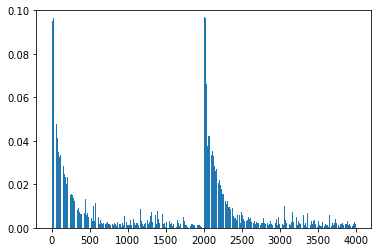

In [30]:
plt.bar(x,Y)
plt.ylim(0,0.1)

In [24]:
plt.show()

In [25]:
f.close()

In [29]:
ct,pt,tt,ft,yt=dataset[100]
ct,pt,tt,ft,yt=trans(ct,pt,tt,ft,yt)
out=net(ct,pt,tt,ft)
rescale(out)
out
loss=crit(rescale(out),rescale(yt))
print(loss.item())

TypeError: '_io.TextIOWrapper' object is not subscriptable